In [1]:
import torch

import numpy as np
import scipy.stats as st
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [3]:
"""
https://github.com/ColCarroll/minimc.git
"""

def leapfrog(q, p, dVdq, potential, path_len, step_size):
    """Leapfrog integrator for Hamiltonian Monte Carlo.
    Parameters
    ----------
    q : np.floatX
        Initial position
    p : np.floatX
        Initial momentum
    dVdq : np.floatX
        Gradient of the potential at the initial coordinates
    potential : callable
        Value and gradient of the potential
    path_len : float
        How long to integrate for
    step_size : float
        How long each integration step should be
    Returns
    -------
    q, p : np.floatX, np.floatX
        New position and momentum
    """
    q, p = np.copy(q), np.copy(p)

    p -= step_size * dVdq / 2  # half step
    for _ in np.arange(path_len):#np.arange(np.round(path_len / step_size) - 1):
        q += step_size * p  # whole step
        V, dVdq = potential(q)
        p -= step_size * dVdq  # whole step
    q += step_size * p  # whole step
    V, dVdq = potential(q)
    p -= step_size * dVdq / 2  # half step

    # momentum flip at end
    return q, -p, V, dVdq

In [43]:
"""
https://github.com/ColCarroll/minimc.git
"""


def hamiltonian_monte_carlo(
    n_samples,
    potential,
    initial_position,
    initial_potential=None,
    initial_potential_grad=None,
    tune=500,
    path_len=100,
    initial_step_size=0.1,
    integrator=leapfrog,
    max_energy_change=1000.0,
):
    """Run Hamiltonian Monte Carlo sampling.
    Parameters
    ----------
    n_samples : int
        Number of samples to return
    negative_log_prob : callable
        The negative log probability to sample from
    initial_position : np.array
        A place to start sampling from.
    tune: int
        Number of iterations to run tuning
    path_len : float
        How long each integration path is. Smaller is faster and more correlated.
    initial_step_size : float
        How long each integration step is. This will be tuned automatically.
    max_energy_change : float
        The largest tolerable integration error. Transitions with energy changes
        larger than this will be declared divergences.
    Returns
    -------
    np.array
        Array of length `n_samples`.
    """
    initial_position = np.array(initial_position)
    if initial_potential is None or initial_potential_grad is None:
        initial_potential, initial_potential_grad = potential(initial_position)

    # collect all our samples in a list
    samples = [initial_position]

    # Keep a single object for momentum resamplingtqdm
    momentum = st.norm(0, 1)

    step_size = initial_step_size
    step_size_tuning = DualAveragingStepSize(step_size)
    
    # If initial_position is a 10d vector and n_samples is 100, we want 100 x 10 momentum draws
    # we can do this in one call to np.random.normal, and iterate over rows
    size = (n_samples + tune,) + initial_position.shape[:1]
    for idx, p0 in tqdm(enumerate(momentum.rvs(size=size)), total=size[0]):
        # Integrate over our path to get a new position and momentum
        q_new, p_new, final_V, final_dVdq = integrator(
            samples[-1],
            p0,
            initial_potential_grad,
            potential,
            path_len=2
            * np.random.rand()
            * path_len,  # We jitter the path length a bit
            step_size=step_size,
        )

        
        start_log_p = np.sum(momentum.logpdf(p0)) - initial_potential
        new_log_p = np.sum(momentum.logpdf(p_new)) - final_V
        energy_change = new_log_p - start_log_p

        # Set accept prob to 0.0 if energy_change is `NaN` which may be
        # the case for a diverging trajectory when using a large step size.
        if np.isnan(np.exp(energy_change)) or np.isnan(p_new).sum():
            p_accept = 0.
        else:
            p_accept = min(1, np.exp(energy_change))

        # Check Metropolis acceptance criterion
        if np.random.rand() < p_accept:
            samples.append(q_new)
            initial_potential = final_V
            initial_potential_grad = final_dVdq
        else:
            samples.append(np.copy(samples[-1]))
        
        if idx < tune - 1:
            step_size, _ = step_size_tuning.update(p_accept)
        elif idx == tune - 1:
            _, step_size = step_size_tuning.update(p_accept)
        
    return np.array(samples[1 + tune :])


class DualAveragingStepSize:
    def __init__(
        self,
        initial_step_size,
        target_accept=0.8,
        gamma=0.05,
        t0=10.0,
        kappa=0.75,
    ):
        """Tune the step size to achieve a desired target acceptance.
        Uses stochastic approximation of Robbins and Monro (1951), described in
        Hoffman and Gelman (2013), section 3.2.1, and using those default values.
        Parameters
        ----------
        initial_step_size: float > 0
            Used to set a reasonable value for the stochastic step to drift towards
        target_accept: float in (0, 1)
            Will try to find a step size that accepts this percent of proposals
        gamma: float
            How quickly the stochastic step size reverts to a value mu
        t0: float > 0
            Larger values stabilize step size exploration early, while perhaps slowing
            convergence
        kappa: float in (0.5, 1]
            The smaller kappa is, the faster we forget earlier step size iterates
        """
        self.mu = np.log(10 * initial_step_size)
        self.target_accept = target_accept
        self.gamma = gamma
        self.t = t0
        self.kappa = kappa
        self.error_sum = 0
        self.log_averaged_step = 0

    def update(self, p_accept):
        """Propose a new step size.
        This method returns both a stochastic step size and a dual-averaged
        step size. While tuning, the HMC algorithm should use the stochastic
        step size and call `update` every loop. After tuning, HMC should use
        the dual-averaged step size for sampling.
        Parameters
        ----------
        p_accept: float
            The probability of the previous HMC proposal being accepted
        Returns
        -------
        float, float
            A stochastic step size, and a dual-averaged step size
        """
        self.error_sum += self.target_accept - p_accept
        log_step = self.mu - self.error_sum / (np.sqrt(self.t) * self.gamma)
        eta = self.t ** -self.kappa
        self.log_averaged_step = (
            eta * log_step + (1 - eta) * self.log_averaged_step
        )
        self.t += 1
        return np.exp(log_step), np.exp(self.log_averaged_step)

In [44]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device ='cpu'

In [45]:
from Tools import logmvn01pdf
def potential(x):
    theta=torch.Tensor(x).requires_grad_(True).float()
    #print(x)
    lp=logmvn01pdf(theta.unsqueeze(0),'cpu')
    lp.backward()
    #print(x)
    return -lp.detach().numpy(), -theta.grad.numpy()

In [32]:
%matplotlib inline
samples = hamiltonian_monte_carlo(5000, potential,
                                  initial_position=np.zeros(1), 
#                                  initial_step_size=0.0001,
#                                  tune=,
#                                 path_len=10,
                                 )
sns.distplot(samples)


3.534726115895444
0.026774495729971513
0.099112764584176
0.32756606320548126
0.9935978993488533
2.791532306013573
0.04948885091212659
0.1426748280204074


/Users/ift/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in multiply
/Users/ift/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


0.3869279639852953
0.9934924692942829
0.9857377379839116
2.360451252644084
0.0763746049145462
0.18609263469040602
0.43480763162505115
0.9099519541372365
1.9975741852720514
0.09070018172725469
0.2012492513338335
0.43468382292407126
0.9115401954368447
1.872562343889791
3.7604364665145793
0.22742595648575173
0.4530839094257336
0.9010785061316892
1.7576200843130125
1.1833620351643672
2.252626751982855
0.17197045502784605
0.3309353068472925
0.6247205117710963
1.1646223080008522
1.4710461741177439
2.676701480246688
0.24376387973338137
0.4132405879234686
0.7476551229864113
1.335869041531436
2.358534539054263
0.24333286143314253
0.43201791760545233
0.7584497251156164
1.2244632642000908
2.106335829570718
0.2418849610859379
0.41809725468715714
0.6990827422210567
1.1857068156493844
1.9930078680318073
0.2511592353947238
0.4159507790327412
0.696223199711764
1.1328131919905038
1.8436461843245902
0.27656117684346326
0.45658219114305393


KeyboardInterrupt: 

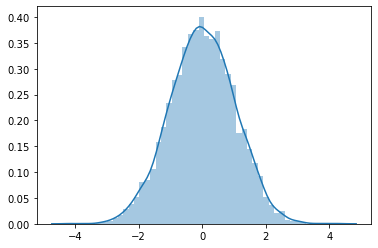

In [19]:
import seaborn as sns                                 
sns.distplot(samples)

# Bayesian inference #

In [33]:
from Experiments.foong import Setup
layerwidth=50
nblayers=1
setup=Setup(device,layerwidth=layerwidth,nblayers=nblayers)

# Target density #

In [34]:
param_count=setup.param_count
logposterior=setup.logposterior



In [46]:
from Inference.PointEstimate import AdamGradientDescent
def _MAP(nbiter, std_init,logposterior, dim, device='cpu'):
        optimizer = AdamGradientDescent(logposterior, nbiter, .01, .00000001, 50, .5, device, True)

        theta0 = torch.empty((1, dim), device=device).normal_(0., std=std_init)
        best_theta, best_score, score = optimizer.run(theta0)

        return best_theta.detach().clone()

theta=_MAP(10000,1., logposterior, param_count)

Epoch [1/10000], Loss: 219838.1875, Learning Rate: 0.01
Epoch [2/10000], Loss: 189238.875, Learning Rate: 0.01
Epoch [3/10000], Loss: 161335.546875, Learning Rate: 0.01
Epoch [4/10000], Loss: 136111.078125, Learning Rate: 0.01
Epoch [5/10000], Loss: 113538.8671875, Learning Rate: 0.01
Epoch [6/10000], Loss: 93570.1171875, Learning Rate: 0.01
Epoch [7/10000], Loss: 76126.09375, Learning Rate: 0.01
Epoch [8/10000], Loss: 61096.75390625, Learning Rate: 0.01
Epoch [9/10000], Loss: 48341.31640625, Learning Rate: 0.01
Epoch [10/10000], Loss: 37691.25390625, Learning Rate: 0.01
Epoch [11/10000], Loss: 28955.0, Learning Rate: 0.01
Epoch [12/10000], Loss: 21924.310546875, Learning Rate: 0.01
Epoch [13/10000], Loss: 16382.11328125, Learning Rate: 0.01
Epoch [14/10000], Loss: 12111.4482421875, Learning Rate: 0.01
Epoch [15/10000], Loss: 8904.541015625, Learning Rate: 0.01
Epoch [16/10000], Loss: 6570.4697265625, Learning Rate: 0.01
Epoch [17/10000], Loss: 4940.4296875, Learning Rate: 0.01
Epoch [

Epoch [199/10000], Loss: 437.20037841796875, Learning Rate: 0.01
Epoch [200/10000], Loss: 435.18951416015625, Learning Rate: 0.01
Epoch [201/10000], Loss: 433.184814453125, Learning Rate: 0.01
Epoch [202/10000], Loss: 431.1864929199219, Learning Rate: 0.01
Epoch [203/10000], Loss: 429.194580078125, Learning Rate: 0.01
Epoch [204/10000], Loss: 427.20892333984375, Learning Rate: 0.01
Epoch [205/10000], Loss: 425.2298583984375, Learning Rate: 0.01
Epoch [206/10000], Loss: 423.25714111328125, Learning Rate: 0.01
Epoch [207/10000], Loss: 421.291015625, Learning Rate: 0.01
Epoch [208/10000], Loss: 419.33160400390625, Learning Rate: 0.01
Epoch [209/10000], Loss: 417.3787536621094, Learning Rate: 0.01
Epoch [210/10000], Loss: 415.43218994140625, Learning Rate: 0.01
Epoch [211/10000], Loss: 413.49237060546875, Learning Rate: 0.01
Epoch [212/10000], Loss: 411.5593566894531, Learning Rate: 0.01
Epoch [213/10000], Loss: 409.63275146484375, Learning Rate: 0.01
Epoch [214/10000], Loss: 407.712982177

Epoch [402/10000], Loss: 173.3208465576172, Learning Rate: 0.01
Epoch [403/10000], Loss: 172.6702880859375, Learning Rate: 0.01
Epoch [404/10000], Loss: 172.0247802734375, Learning Rate: 0.01
Epoch [405/10000], Loss: 171.3843231201172, Learning Rate: 0.01
Epoch [406/10000], Loss: 170.7489013671875, Learning Rate: 0.01
Epoch [407/10000], Loss: 170.11856079101562, Learning Rate: 0.01
Epoch [408/10000], Loss: 169.49331665039062, Learning Rate: 0.01
Epoch [409/10000], Loss: 168.87307739257812, Learning Rate: 0.01
Epoch [410/10000], Loss: 168.25802612304688, Learning Rate: 0.01
Epoch [411/10000], Loss: 167.64804077148438, Learning Rate: 0.01
Epoch [412/10000], Loss: 167.04315185546875, Learning Rate: 0.01
Epoch [413/10000], Loss: 166.4434814453125, Learning Rate: 0.01
Epoch [414/10000], Loss: 165.84909057617188, Learning Rate: 0.01
Epoch [415/10000], Loss: 165.25991821289062, Learning Rate: 0.01
Epoch [416/10000], Loss: 164.67587280273438, Learning Rate: 0.01
Epoch [417/10000], Loss: 164.09

Epoch [579/10000], Loss: 130.37596130371094, Learning Rate: 0.01
Epoch [580/10000], Loss: 130.32769775390625, Learning Rate: 0.01
Epoch [581/10000], Loss: 130.27993774414062, Learning Rate: 0.01
Epoch [582/10000], Loss: 130.23239135742188, Learning Rate: 0.01
Epoch [583/10000], Loss: 130.1852569580078, Learning Rate: 0.01
Epoch [584/10000], Loss: 130.13848876953125, Learning Rate: 0.01
Epoch [585/10000], Loss: 130.09205627441406, Learning Rate: 0.01
Epoch [586/10000], Loss: 130.04592895507812, Learning Rate: 0.01
Epoch [587/10000], Loss: 130.00009155273438, Learning Rate: 0.01
Epoch [588/10000], Loss: 129.9547119140625, Learning Rate: 0.01
Epoch [589/10000], Loss: 129.909423828125, Learning Rate: 0.01
Epoch [590/10000], Loss: 129.86465454101562, Learning Rate: 0.01
Epoch [591/10000], Loss: 129.82015991210938, Learning Rate: 0.01
Epoch [592/10000], Loss: 129.7759246826172, Learning Rate: 0.01
Epoch [593/10000], Loss: 129.73190307617188, Learning Rate: 0.01
Epoch [594/10000], Loss: 129.6

Epoch [773/10000], Loss: 123.52094268798828, Learning Rate: 0.01
Epoch [774/10000], Loss: 123.4885025024414, Learning Rate: 0.01
Epoch [775/10000], Loss: 123.4561996459961, Learning Rate: 0.01
Epoch [776/10000], Loss: 123.42378997802734, Learning Rate: 0.01
Epoch [777/10000], Loss: 123.39154052734375, Learning Rate: 0.01
Epoch [778/10000], Loss: 123.3592529296875, Learning Rate: 0.01
Epoch [779/10000], Loss: 123.3270492553711, Learning Rate: 0.01
Epoch [780/10000], Loss: 123.29472351074219, Learning Rate: 0.01
Epoch [781/10000], Loss: 123.2625732421875, Learning Rate: 0.01
Epoch [782/10000], Loss: 123.23021697998047, Learning Rate: 0.01
Epoch [783/10000], Loss: 123.19811248779297, Learning Rate: 0.01
Epoch [784/10000], Loss: 123.1658706665039, Learning Rate: 0.01
Epoch [785/10000], Loss: 123.13378143310547, Learning Rate: 0.01
Epoch [786/10000], Loss: 123.10161590576172, Learning Rate: 0.01
Epoch [787/10000], Loss: 123.06951904296875, Learning Rate: 0.01
Epoch [788/10000], Loss: 123.03

Epoch [932/10000], Loss: 119.01959228515625, Learning Rate: 0.01
Epoch [933/10000], Loss: 118.99655151367188, Learning Rate: 0.01
Epoch [934/10000], Loss: 118.97367858886719, Learning Rate: 0.01
Epoch [935/10000], Loss: 118.95060729980469, Learning Rate: 0.01
Epoch [936/10000], Loss: 118.92789459228516, Learning Rate: 0.01
Epoch [937/10000], Loss: 118.90513610839844, Learning Rate: 0.01
Epoch [938/10000], Loss: 118.88235473632812, Learning Rate: 0.01
Epoch [939/10000], Loss: 118.85969543457031, Learning Rate: 0.01
Epoch [940/10000], Loss: 118.83702850341797, Learning Rate: 0.01
Epoch [941/10000], Loss: 118.81449890136719, Learning Rate: 0.01
Epoch [942/10000], Loss: 118.79193878173828, Learning Rate: 0.01
Epoch [943/10000], Loss: 118.7695541381836, Learning Rate: 0.01
Epoch [944/10000], Loss: 118.74716186523438, Learning Rate: 0.01
Epoch [945/10000], Loss: 118.72474670410156, Learning Rate: 0.01
Epoch [946/10000], Loss: 118.70250701904297, Learning Rate: 0.01
Epoch [947/10000], Loss: 1

Epoch [1100/10000], Loss: 115.75556945800781, Learning Rate: 0.01
Epoch [1101/10000], Loss: 115.73870849609375, Learning Rate: 0.01
Epoch [1102/10000], Loss: 115.72191619873047, Learning Rate: 0.01
Epoch [1103/10000], Loss: 115.70507049560547, Learning Rate: 0.01
Epoch [1104/10000], Loss: 115.688232421875, Learning Rate: 0.01
Epoch [1105/10000], Loss: 115.67156982421875, Learning Rate: 0.01
Epoch [1106/10000], Loss: 115.65485382080078, Learning Rate: 0.01
Epoch [1107/10000], Loss: 115.63811492919922, Learning Rate: 0.01
Epoch [1108/10000], Loss: 115.62133026123047, Learning Rate: 0.01
Epoch [1109/10000], Loss: 115.60459899902344, Learning Rate: 0.01
Epoch [1110/10000], Loss: 115.58797454833984, Learning Rate: 0.01
Epoch [1111/10000], Loss: 115.57136535644531, Learning Rate: 0.01
Epoch [1112/10000], Loss: 115.55477905273438, Learning Rate: 0.01
Epoch [1113/10000], Loss: 115.53816986083984, Learning Rate: 0.01
Epoch [1114/10000], Loss: 115.52156829833984, Learning Rate: 0.01
Epoch [1115/

Epoch [1304/10000], Loss: 112.63921356201172, Learning Rate: 0.01
Epoch [1305/10000], Loss: 112.62512969970703, Learning Rate: 0.01
Epoch [1306/10000], Loss: 112.61094665527344, Learning Rate: 0.01
Epoch [1307/10000], Loss: 112.59687042236328, Learning Rate: 0.01
Epoch [1308/10000], Loss: 112.5827407836914, Learning Rate: 0.01
Epoch [1309/10000], Loss: 112.568603515625, Learning Rate: 0.01
Epoch [1310/10000], Loss: 112.55443572998047, Learning Rate: 0.01
Epoch [1311/10000], Loss: 112.54043579101562, Learning Rate: 0.01
Epoch [1312/10000], Loss: 112.5263671875, Learning Rate: 0.01
Epoch [1313/10000], Loss: 112.51216888427734, Learning Rate: 0.01
Epoch [1314/10000], Loss: 112.49818420410156, Learning Rate: 0.01
Epoch [1315/10000], Loss: 112.48408508300781, Learning Rate: 0.01
Epoch [1316/10000], Loss: 112.469970703125, Learning Rate: 0.01
Epoch [1317/10000], Loss: 112.45600128173828, Learning Rate: 0.01
Epoch [1318/10000], Loss: 112.44194793701172, Learning Rate: 0.01
Epoch [1319/10000],

Epoch [1492/10000], Loss: 110.0948486328125, Learning Rate: 0.01
Epoch [1493/10000], Loss: 110.08187866210938, Learning Rate: 0.01
Epoch [1494/10000], Loss: 110.06890869140625, Learning Rate: 0.01
Epoch [1495/10000], Loss: 110.05599975585938, Learning Rate: 0.01
Epoch [1496/10000], Loss: 110.04304504394531, Learning Rate: 0.01
Epoch [1497/10000], Loss: 110.03005981445312, Learning Rate: 0.01
Epoch [1498/10000], Loss: 110.01709747314453, Learning Rate: 0.01
Epoch [1499/10000], Loss: 110.0042724609375, Learning Rate: 0.01
Epoch [1500/10000], Loss: 109.99124145507812, Learning Rate: 0.01
Epoch [1501/10000], Loss: 109.97827911376953, Learning Rate: 0.01
Epoch [1502/10000], Loss: 109.96542358398438, Learning Rate: 0.01
Epoch [1503/10000], Loss: 109.95260620117188, Learning Rate: 0.01
Epoch [1504/10000], Loss: 109.93966674804688, Learning Rate: 0.01
Epoch [1505/10000], Loss: 109.92668151855469, Learning Rate: 0.01
Epoch [1506/10000], Loss: 109.9138412475586, Learning Rate: 0.01
Epoch [1507/1

Epoch [1680/10000], Loss: 107.77201843261719, Learning Rate: 0.01
Epoch [1681/10000], Loss: 107.76024627685547, Learning Rate: 0.01
Epoch [1682/10000], Loss: 107.74845123291016, Learning Rate: 0.01
Epoch [1683/10000], Loss: 107.73682403564453, Learning Rate: 0.01
Epoch [1684/10000], Loss: 107.72505950927734, Learning Rate: 0.01
Epoch [1685/10000], Loss: 107.71339416503906, Learning Rate: 0.01
Epoch [1686/10000], Loss: 107.70170593261719, Learning Rate: 0.01
Epoch [1687/10000], Loss: 107.68997192382812, Learning Rate: 0.01
Epoch [1688/10000], Loss: 107.67826843261719, Learning Rate: 0.01
Epoch [1689/10000], Loss: 107.66654968261719, Learning Rate: 0.01
Epoch [1690/10000], Loss: 107.65486145019531, Learning Rate: 0.01
Epoch [1691/10000], Loss: 107.64312744140625, Learning Rate: 0.01
Epoch [1692/10000], Loss: 107.63143157958984, Learning Rate: 0.01
Epoch [1693/10000], Loss: 107.61979675292969, Learning Rate: 0.01
Epoch [1694/10000], Loss: 107.6081314086914, Learning Rate: 0.01
Epoch [1695

Epoch [1871/10000], Loss: 105.61666107177734, Learning Rate: 0.01
Epoch [1872/10000], Loss: 105.60572814941406, Learning Rate: 0.01
Epoch [1873/10000], Loss: 105.59481811523438, Learning Rate: 0.01
Epoch [1874/10000], Loss: 105.5839614868164, Learning Rate: 0.01
Epoch [1875/10000], Loss: 105.57296752929688, Learning Rate: 0.01
Epoch [1876/10000], Loss: 105.56217956542969, Learning Rate: 0.01
Epoch [1877/10000], Loss: 105.5512466430664, Learning Rate: 0.01
Epoch [1878/10000], Loss: 105.54035949707031, Learning Rate: 0.01
Epoch [1879/10000], Loss: 105.5294418334961, Learning Rate: 0.01
Epoch [1880/10000], Loss: 105.51854705810547, Learning Rate: 0.01
Epoch [1881/10000], Loss: 105.50768280029297, Learning Rate: 0.01
Epoch [1882/10000], Loss: 105.4968490600586, Learning Rate: 0.01
Epoch [1883/10000], Loss: 105.4859619140625, Learning Rate: 0.01
Epoch [1884/10000], Loss: 105.47509765625, Learning Rate: 0.01
Epoch [1885/10000], Loss: 105.46431732177734, Learning Rate: 0.01
Epoch [1886/10000]

Epoch [2008/10000], Loss: 104.15029907226562, Learning Rate: 0.01
Epoch [2009/10000], Loss: 104.1397705078125, Learning Rate: 0.01
Epoch [2010/10000], Loss: 104.12925720214844, Learning Rate: 0.01
Epoch [2011/10000], Loss: 104.11876678466797, Learning Rate: 0.01
Epoch [2012/10000], Loss: 104.10816192626953, Learning Rate: 0.01
Epoch [2013/10000], Loss: 104.09770965576172, Learning Rate: 0.01
Epoch [2014/10000], Loss: 104.08719635009766, Learning Rate: 0.01
Epoch [2015/10000], Loss: 104.07675170898438, Learning Rate: 0.01
Epoch [2016/10000], Loss: 104.06620025634766, Learning Rate: 0.01
Epoch [2017/10000], Loss: 104.05573272705078, Learning Rate: 0.01
Epoch [2018/10000], Loss: 104.04522705078125, Learning Rate: 0.01
Epoch [2019/10000], Loss: 104.03472137451172, Learning Rate: 0.01
Epoch [2020/10000], Loss: 104.0241470336914, Learning Rate: 0.01
Epoch [2021/10000], Loss: 104.01373291015625, Learning Rate: 0.01
Epoch [2022/10000], Loss: 104.00330352783203, Learning Rate: 0.01
Epoch [2023/

Epoch [2187/10000], Loss: 102.30341339111328, Learning Rate: 0.01
Epoch [2188/10000], Loss: 102.29328155517578, Learning Rate: 0.01
Epoch [2189/10000], Loss: 102.28321075439453, Learning Rate: 0.01
Epoch [2190/10000], Loss: 102.27301025390625, Learning Rate: 0.01
Epoch [2191/10000], Loss: 102.26280975341797, Learning Rate: 0.01
Epoch [2192/10000], Loss: 102.2527847290039, Learning Rate: 0.01
Epoch [2193/10000], Loss: 102.24274444580078, Learning Rate: 0.01
Epoch [2194/10000], Loss: 102.23255157470703, Learning Rate: 0.01
Epoch [2195/10000], Loss: 102.22235107421875, Learning Rate: 0.01
Epoch [2196/10000], Loss: 102.21228790283203, Learning Rate: 0.01
Epoch [2197/10000], Loss: 102.20215606689453, Learning Rate: 0.01
Epoch [2198/10000], Loss: 102.19208526611328, Learning Rate: 0.01
Epoch [2199/10000], Loss: 102.18196868896484, Learning Rate: 0.01
Epoch [2200/10000], Loss: 102.17192077636719, Learning Rate: 0.01
Epoch [2201/10000], Loss: 102.1617202758789, Learning Rate: 0.01
Epoch [2202/

Epoch [2356/10000], Loss: 100.61687469482422, Learning Rate: 0.01
Epoch [2357/10000], Loss: 100.6070785522461, Learning Rate: 0.01
Epoch [2358/10000], Loss: 100.59720611572266, Learning Rate: 0.01
Epoch [2359/10000], Loss: 100.5874252319336, Learning Rate: 0.01
Epoch [2360/10000], Loss: 100.57759857177734, Learning Rate: 0.01
Epoch [2361/10000], Loss: 100.56774139404297, Learning Rate: 0.01
Epoch [2362/10000], Loss: 100.55796813964844, Learning Rate: 0.01
Epoch [2363/10000], Loss: 100.54803466796875, Learning Rate: 0.01
Epoch [2364/10000], Loss: 100.53829956054688, Learning Rate: 0.01
Epoch [2365/10000], Loss: 100.52841186523438, Learning Rate: 0.01
Epoch [2366/10000], Loss: 100.51863861083984, Learning Rate: 0.01
Epoch [2367/10000], Loss: 100.50882720947266, Learning Rate: 0.01
Epoch [2368/10000], Loss: 100.49898529052734, Learning Rate: 0.01
Epoch [2369/10000], Loss: 100.48919677734375, Learning Rate: 0.01
Epoch [2370/10000], Loss: 100.47941589355469, Learning Rate: 0.01
Epoch [2371/

Epoch [2530/10000], Loss: 98.92998504638672, Learning Rate: 0.01
Epoch [2531/10000], Loss: 98.9205322265625, Learning Rate: 0.01
Epoch [2532/10000], Loss: 98.91094970703125, Learning Rate: 0.01
Epoch [2533/10000], Loss: 98.90141296386719, Learning Rate: 0.01
Epoch [2534/10000], Loss: 98.891845703125, Learning Rate: 0.01
Epoch [2535/10000], Loss: 98.88232421875, Learning Rate: 0.01
Epoch [2536/10000], Loss: 98.87268829345703, Learning Rate: 0.01
Epoch [2537/10000], Loss: 98.86320495605469, Learning Rate: 0.01
Epoch [2538/10000], Loss: 98.8535385131836, Learning Rate: 0.01
Epoch [2539/10000], Loss: 98.84415435791016, Learning Rate: 0.01
Epoch [2540/10000], Loss: 98.83450317382812, Learning Rate: 0.01
Epoch [2541/10000], Loss: 98.82499694824219, Learning Rate: 0.01
Epoch [2542/10000], Loss: 98.81544494628906, Learning Rate: 0.01
Epoch [2543/10000], Loss: 98.8058853149414, Learning Rate: 0.01
Epoch [2544/10000], Loss: 98.79641723632812, Learning Rate: 0.01
Epoch [2545/10000], Loss: 98.7867

Epoch [2718/10000], Loss: 97.15841674804688, Learning Rate: 0.01
Epoch [2719/10000], Loss: 97.14916229248047, Learning Rate: 0.01
Epoch [2720/10000], Loss: 97.13984680175781, Learning Rate: 0.01
Epoch [2721/10000], Loss: 97.13058471679688, Learning Rate: 0.01
Epoch [2722/10000], Loss: 97.12127685546875, Learning Rate: 0.01
Epoch [2723/10000], Loss: 97.11205291748047, Learning Rate: 0.01
Epoch [2724/10000], Loss: 97.10271453857422, Learning Rate: 0.01
Epoch [2725/10000], Loss: 97.09344482421875, Learning Rate: 0.01
Epoch [2726/10000], Loss: 97.08419036865234, Learning Rate: 0.01
Epoch [2727/10000], Loss: 97.07486724853516, Learning Rate: 0.01
Epoch [2728/10000], Loss: 97.06553649902344, Learning Rate: 0.01
Epoch [2729/10000], Loss: 97.05632781982422, Learning Rate: 0.01
Epoch [2730/10000], Loss: 97.04695129394531, Learning Rate: 0.01
Epoch [2731/10000], Loss: 97.03768920898438, Learning Rate: 0.01
Epoch [2732/10000], Loss: 97.02845001220703, Learning Rate: 0.01
Epoch [2733/10000], Loss:

Epoch [2905/10000], Loss: 95.44338989257812, Learning Rate: 0.01
Epoch [2906/10000], Loss: 95.4344482421875, Learning Rate: 0.01
Epoch [2907/10000], Loss: 95.42534637451172, Learning Rate: 0.01
Epoch [2908/10000], Loss: 95.41634368896484, Learning Rate: 0.01
Epoch [2909/10000], Loss: 95.40725708007812, Learning Rate: 0.01
Epoch [2910/10000], Loss: 95.39820098876953, Learning Rate: 0.01
Epoch [2911/10000], Loss: 95.38916015625, Learning Rate: 0.01
Epoch [2912/10000], Loss: 95.38006591796875, Learning Rate: 0.01
Epoch [2913/10000], Loss: 95.37116241455078, Learning Rate: 0.01
Epoch [2914/10000], Loss: 95.36199188232422, Learning Rate: 0.01
Epoch [2915/10000], Loss: 95.35295867919922, Learning Rate: 0.01
Epoch [2916/10000], Loss: 95.34390258789062, Learning Rate: 0.01
Epoch [2917/10000], Loss: 95.3349838256836, Learning Rate: 0.01
Epoch [2918/10000], Loss: 95.32587432861328, Learning Rate: 0.01
Epoch [2919/10000], Loss: 95.31688690185547, Learning Rate: 0.01
Epoch [2920/10000], Loss: 95.3

Epoch [3109/10000], Loss: 93.62008666992188, Learning Rate: 0.01
Epoch [3110/10000], Loss: 93.61135864257812, Learning Rate: 0.01
Epoch [3111/10000], Loss: 93.6024398803711, Learning Rate: 0.01
Epoch [3112/10000], Loss: 93.59364318847656, Learning Rate: 0.01
Epoch [3113/10000], Loss: 93.58483123779297, Learning Rate: 0.01
Epoch [3114/10000], Loss: 93.57603454589844, Learning Rate: 0.01
Epoch [3115/10000], Loss: 93.56720733642578, Learning Rate: 0.01
Epoch [3116/10000], Loss: 93.5583267211914, Learning Rate: 0.01
Epoch [3117/10000], Loss: 93.54946899414062, Learning Rate: 0.01
Epoch [3118/10000], Loss: 93.54066467285156, Learning Rate: 0.01
Epoch [3119/10000], Loss: 93.53192138671875, Learning Rate: 0.01
Epoch [3120/10000], Loss: 93.52310180664062, Learning Rate: 0.01
Epoch [3121/10000], Loss: 93.51423645019531, Learning Rate: 0.01
Epoch [3122/10000], Loss: 93.5054702758789, Learning Rate: 0.01
Epoch [3123/10000], Loss: 93.4966049194336, Learning Rate: 0.01
Epoch [3124/10000], Loss: 93.

Epoch [3303/10000], Loss: 91.92682647705078, Learning Rate: 0.01
Epoch [3304/10000], Loss: 91.91814422607422, Learning Rate: 0.01
Epoch [3305/10000], Loss: 91.90957641601562, Learning Rate: 0.01
Epoch [3306/10000], Loss: 91.9009017944336, Learning Rate: 0.01
Epoch [3307/10000], Loss: 91.89226531982422, Learning Rate: 0.01
Epoch [3308/10000], Loss: 91.88365936279297, Learning Rate: 0.01
Epoch [3309/10000], Loss: 91.8750228881836, Learning Rate: 0.01
Epoch [3310/10000], Loss: 91.86646270751953, Learning Rate: 0.01
Epoch [3311/10000], Loss: 91.85778045654297, Learning Rate: 0.01
Epoch [3312/10000], Loss: 91.84915924072266, Learning Rate: 0.01
Epoch [3313/10000], Loss: 91.84052276611328, Learning Rate: 0.01
Epoch [3314/10000], Loss: 91.83190155029297, Learning Rate: 0.01
Epoch [3315/10000], Loss: 91.8232421875, Learning Rate: 0.01
Epoch [3316/10000], Loss: 91.81459045410156, Learning Rate: 0.01
Epoch [3317/10000], Loss: 91.80597686767578, Learning Rate: 0.01
Epoch [3318/10000], Loss: 91.79

Epoch [3515/10000], Loss: 90.11750793457031, Learning Rate: 0.01
Epoch [3516/10000], Loss: 90.10903930664062, Learning Rate: 0.01
Epoch [3517/10000], Loss: 90.1005630493164, Learning Rate: 0.01
Epoch [3518/10000], Loss: 90.09208679199219, Learning Rate: 0.01
Epoch [3519/10000], Loss: 90.0837173461914, Learning Rate: 0.01
Epoch [3520/10000], Loss: 90.07524108886719, Learning Rate: 0.01
Epoch [3521/10000], Loss: 90.06685638427734, Learning Rate: 0.01
Epoch [3522/10000], Loss: 90.05843353271484, Learning Rate: 0.01
Epoch [3523/10000], Loss: 90.0499496459961, Learning Rate: 0.01
Epoch [3524/10000], Loss: 90.04157257080078, Learning Rate: 0.01
Epoch [3525/10000], Loss: 90.03314208984375, Learning Rate: 0.01
Epoch [3526/10000], Loss: 90.02460479736328, Learning Rate: 0.01
Epoch [3527/10000], Loss: 90.0162582397461, Learning Rate: 0.01
Epoch [3528/10000], Loss: 90.00782775878906, Learning Rate: 0.01
Epoch [3529/10000], Loss: 89.99948120117188, Learning Rate: 0.01
Epoch [3530/10000], Loss: 89.

Epoch [3701/10000], Loss: 88.56407165527344, Learning Rate: 0.01
Epoch [3702/10000], Loss: 88.5558090209961, Learning Rate: 0.01
Epoch [3703/10000], Loss: 88.54749298095703, Learning Rate: 0.01
Epoch [3704/10000], Loss: 88.53927612304688, Learning Rate: 0.01
Epoch [3705/10000], Loss: 88.53099060058594, Learning Rate: 0.01
Epoch [3706/10000], Loss: 88.52275085449219, Learning Rate: 0.01
Epoch [3707/10000], Loss: 88.51445007324219, Learning Rate: 0.01
Epoch [3708/10000], Loss: 88.50630187988281, Learning Rate: 0.01
Epoch [3709/10000], Loss: 88.4979248046875, Learning Rate: 0.01
Epoch [3710/10000], Loss: 88.48971557617188, Learning Rate: 0.01
Epoch [3711/10000], Loss: 88.48149108886719, Learning Rate: 0.01
Epoch [3712/10000], Loss: 88.4731674194336, Learning Rate: 0.01
Epoch [3713/10000], Loss: 88.46495819091797, Learning Rate: 0.01
Epoch [3714/10000], Loss: 88.45671081542969, Learning Rate: 0.01
Epoch [3715/10000], Loss: 88.44851684570312, Learning Rate: 0.01
Epoch [3716/10000], Loss: 88

Epoch [3887/10000], Loss: 87.04409790039062, Learning Rate: 0.01
Epoch [3888/10000], Loss: 87.03599548339844, Learning Rate: 0.01
Epoch [3889/10000], Loss: 87.02790832519531, Learning Rate: 0.01
Epoch [3890/10000], Loss: 87.01988220214844, Learning Rate: 0.01
Epoch [3891/10000], Loss: 87.01180267333984, Learning Rate: 0.01
Epoch [3892/10000], Loss: 87.0037612915039, Learning Rate: 0.01
Epoch [3893/10000], Loss: 86.99569702148438, Learning Rate: 0.01
Epoch [3894/10000], Loss: 86.98758697509766, Learning Rate: 0.01
Epoch [3895/10000], Loss: 86.9794692993164, Learning Rate: 0.01
Epoch [3896/10000], Loss: 86.9714584350586, Learning Rate: 0.01
Epoch [3897/10000], Loss: 86.96343231201172, Learning Rate: 0.01
Epoch [3898/10000], Loss: 86.9553451538086, Learning Rate: 0.01
Epoch [3899/10000], Loss: 86.94721221923828, Learning Rate: 0.01
Epoch [3900/10000], Loss: 86.93917846679688, Learning Rate: 0.01
Epoch [3901/10000], Loss: 86.93113708496094, Learning Rate: 0.01
Epoch [3902/10000], Loss: 86.

Epoch [4083/10000], Loss: 85.48544311523438, Learning Rate: 0.01
Epoch [4084/10000], Loss: 85.47764587402344, Learning Rate: 0.01
Epoch [4085/10000], Loss: 85.46983337402344, Learning Rate: 0.01
Epoch [4086/10000], Loss: 85.4620361328125, Learning Rate: 0.01
Epoch [4087/10000], Loss: 85.4542007446289, Learning Rate: 0.01
Epoch [4088/10000], Loss: 85.44638061523438, Learning Rate: 0.01
Epoch [4089/10000], Loss: 85.43865203857422, Learning Rate: 0.01
Epoch [4090/10000], Loss: 85.4307861328125, Learning Rate: 0.01
Epoch [4091/10000], Loss: 85.42302703857422, Learning Rate: 0.01
Epoch [4092/10000], Loss: 85.41522216796875, Learning Rate: 0.01
Epoch [4093/10000], Loss: 85.40740203857422, Learning Rate: 0.01
Epoch [4094/10000], Loss: 85.39966583251953, Learning Rate: 0.01
Epoch [4095/10000], Loss: 85.39171600341797, Learning Rate: 0.01
Epoch [4096/10000], Loss: 85.38401794433594, Learning Rate: 0.01
Epoch [4097/10000], Loss: 85.37622833251953, Learning Rate: 0.01
Epoch [4098/10000], Loss: 85

Epoch [4260/10000], Loss: 84.13809204101562, Learning Rate: 0.01
Epoch [4261/10000], Loss: 84.13571166992188, Learning Rate: 0.01
Epoch [4262/10000], Loss: 84.13626861572266, Learning Rate: 0.01
Epoch [4263/10000], Loss: 84.14104461669922, Learning Rate: 0.01
Epoch [4264/10000], Loss: 84.15017700195312, Learning Rate: 0.01
Epoch [4265/10000], Loss: 84.16188049316406, Learning Rate: 0.01
Epoch [4266/10000], Loss: 84.16963958740234, Learning Rate: 0.01
Epoch [4267/10000], Loss: 84.16337585449219, Learning Rate: 0.01
Epoch [4268/10000], Loss: 84.13653564453125, Learning Rate: 0.01
Epoch [4269/10000], Loss: 84.09622955322266, Learning Rate: 0.01
Epoch [4270/10000], Loss: 84.06207275390625, Learning Rate: 0.01
Epoch [4271/10000], Loss: 84.0487289428711, Learning Rate: 0.01
Epoch [4272/10000], Loss: 84.05461120605469, Learning Rate: 0.01
Epoch [4273/10000], Loss: 84.0644760131836, Learning Rate: 0.01
Epoch [4274/10000], Loss: 84.06266021728516, Learning Rate: 0.01
Epoch [4275/10000], Loss: 8

Epoch [4467/10000], Loss: 82.69549560546875, Learning Rate: 0.01
Epoch [4468/10000], Loss: 82.70906829833984, Learning Rate: 0.01
Epoch [4469/10000], Loss: 82.72010040283203, Learning Rate: 0.01
Epoch [4470/10000], Loss: 82.71947479248047, Learning Rate: 0.01
Epoch [4471/10000], Loss: 82.6998291015625, Learning Rate: 0.01
Epoch [4472/10000], Loss: 82.66210174560547, Learning Rate: 0.01
Epoch [4473/10000], Loss: 82.61997985839844, Learning Rate: 0.01
Epoch [4474/10000], Loss: 82.59095764160156, Learning Rate: 0.01
Epoch [4475/10000], Loss: 82.5837173461914, Learning Rate: 0.01
Epoch [4476/10000], Loss: 82.59217834472656, Learning Rate: 0.01
Epoch [4477/10000], Loss: 82.60248565673828, Learning Rate: 0.01
Epoch [4478/10000], Loss: 82.60177612304688, Learning Rate: 0.01
Epoch [4479/10000], Loss: 82.58607482910156, Learning Rate: 0.01
Epoch [4480/10000], Loss: 82.56229400634766, Learning Rate: 0.01
Epoch [4481/10000], Loss: 82.54236602783203, Learning Rate: 0.01
Epoch [4482/10000], Loss: 8

Epoch [4673/10000], Loss: 81.27622985839844, Learning Rate: 0.01
Epoch [4674/10000], Loss: 81.26957702636719, Learning Rate: 0.01
Epoch [4675/10000], Loss: 81.260986328125, Learning Rate: 0.01
Epoch [4676/10000], Loss: 81.25204467773438, Learning Rate: 0.01
Epoch [4677/10000], Loss: 81.24455261230469, Learning Rate: 0.01
Epoch [4678/10000], Loss: 81.23867797851562, Learning Rate: 0.01
Epoch [4679/10000], Loss: 81.23368072509766, Learning Rate: 0.01
Epoch [4680/10000], Loss: 81.22850036621094, Learning Rate: 0.01
Epoch [4681/10000], Loss: 81.22224426269531, Learning Rate: 0.01
Epoch [4682/10000], Loss: 81.21505737304688, Learning Rate: 0.01
Epoch [4683/10000], Loss: 81.20753479003906, Learning Rate: 0.01
Epoch [4684/10000], Loss: 81.2004165649414, Learning Rate: 0.01
Epoch [4685/10000], Loss: 81.19406127929688, Learning Rate: 0.01
Epoch [4686/10000], Loss: 81.18826293945312, Learning Rate: 0.01
Epoch [4687/10000], Loss: 81.18260955810547, Learning Rate: 0.01
Epoch [4688/10000], Loss: 81

Epoch [4852/10000], Loss: 80.18133544921875, Learning Rate: 0.01
Epoch [4853/10000], Loss: 80.17282104492188, Learning Rate: 0.01
Epoch [4854/10000], Loss: 80.16448211669922, Learning Rate: 0.01
Epoch [4855/10000], Loss: 80.15779113769531, Learning Rate: 0.01
Epoch [4856/10000], Loss: 80.1528549194336, Learning Rate: 0.01
Epoch [4857/10000], Loss: 80.14848327636719, Learning Rate: 0.01
Epoch [4858/10000], Loss: 80.14346313476562, Learning Rate: 0.01
Epoch [4859/10000], Loss: 80.13720703125, Learning Rate: 0.01
Epoch [4860/10000], Loss: 80.13001251220703, Learning Rate: 0.01
Epoch [4861/10000], Loss: 80.12299346923828, Learning Rate: 0.01
Epoch [4862/10000], Loss: 80.11663055419922, Learning Rate: 0.01
Epoch [4863/10000], Loss: 80.11117553710938, Learning Rate: 0.01
Epoch [4864/10000], Loss: 80.10601043701172, Learning Rate: 0.01
Epoch [4865/10000], Loss: 80.1006088256836, Learning Rate: 0.01
Epoch [4866/10000], Loss: 80.09466552734375, Learning Rate: 0.01
Epoch [4867/10000], Loss: 80.0

Epoch [5032/10000], Loss: 79.15876007080078, Learning Rate: 0.01
Epoch [5033/10000], Loss: 79.14553833007812, Learning Rate: 0.01
Epoch [5034/10000], Loss: 79.13584899902344, Learning Rate: 0.01
Epoch [5035/10000], Loss: 79.13150787353516, Learning Rate: 0.01
Epoch [5036/10000], Loss: 79.13025665283203, Learning Rate: 0.01
Epoch [5037/10000], Loss: 79.12805938720703, Learning Rate: 0.01
Epoch [5038/10000], Loss: 79.12261962890625, Learning Rate: 0.01
Epoch [5039/10000], Loss: 79.11407470703125, Learning Rate: 0.01
Epoch [5040/10000], Loss: 79.10491180419922, Learning Rate: 0.01
Epoch [5041/10000], Loss: 79.09724426269531, Learning Rate: 0.01
Epoch [5042/10000], Loss: 79.09203338623047, Learning Rate: 0.01
Epoch [5043/10000], Loss: 79.0883560180664, Learning Rate: 0.01
Epoch [5044/10000], Loss: 79.0845947265625, Learning Rate: 0.01
Epoch [5045/10000], Loss: 79.0794448852539, Learning Rate: 0.01
Epoch [5046/10000], Loss: 79.07292175292969, Learning Rate: 0.01
Epoch [5047/10000], Loss: 79

Epoch [5216/10000], Loss: 78.16190338134766, Learning Rate: 0.01
Epoch [5217/10000], Loss: 78.1857681274414, Learning Rate: 0.01
Epoch [5218/10000], Loss: 78.2012939453125, Learning Rate: 0.01
Epoch [5219/10000], Loss: 78.18881225585938, Learning Rate: 0.01
Epoch [5220/10000], Loss: 78.15752410888672, Learning Rate: 0.01
Epoch [5221/10000], Loss: 78.13167572021484, Learning Rate: 0.01
Epoch [5222/10000], Loss: 78.12645721435547, Learning Rate: 0.01
Epoch [5223/10000], Loss: 78.13602447509766, Learning Rate: 0.01
Epoch [5224/10000], Loss: 78.14305877685547, Learning Rate: 0.01
Epoch [5225/10000], Loss: 78.13583374023438, Learning Rate: 0.01
Epoch [5226/10000], Loss: 78.11743927001953, Learning Rate: 0.01
Epoch [5227/10000], Loss: 78.1002197265625, Learning Rate: 0.01
Epoch [5228/10000], Loss: 78.0931396484375, Learning Rate: 0.01
Epoch [5229/10000], Loss: 78.09489440917969, Learning Rate: 0.01
Epoch [5230/10000], Loss: 78.09706115722656, Learning Rate: 0.01
Epoch [5231/10000], Loss: 78.

Epoch [5408/10000], Loss: 77.87549591064453, Learning Rate: 0.01
Epoch [5409/10000], Loss: 78.17493438720703, Learning Rate: 0.01
Epoch [5410/10000], Loss: 78.48033905029297, Learning Rate: 0.01
Epoch [5411/10000], Loss: 78.66551971435547, Learning Rate: 0.01
Epoch [5412/10000], Loss: 78.57647705078125, Learning Rate: 0.01
Epoch [5413/10000], Loss: 78.17030334472656, Learning Rate: 0.01
Epoch [5414/10000], Loss: 77.61744689941406, Learning Rate: 0.01
Epoch [5415/10000], Loss: 77.21665954589844, Learning Rate: 0.01
Epoch [5416/10000], Loss: 77.15434265136719, Learning Rate: 0.01
Epoch [5417/10000], Loss: 77.37259674072266, Learning Rate: 0.01
Epoch [5418/10000], Loss: 77.64311981201172, Learning Rate: 0.01
Epoch [5419/10000], Loss: 77.74063110351562, Learning Rate: 0.01
Epoch [5420/10000], Loss: 77.59282684326172, Learning Rate: 0.01
Epoch [5421/10000], Loss: 77.32041931152344, Learning Rate: 0.01
Epoch [5422/10000], Loss: 77.12741088867188, Learning Rate: 0.01
Epoch [5423/10000], Loss:

Epoch [5586/10000], Loss: 76.3091812133789, Learning Rate: 0.01
Epoch [5587/10000], Loss: 76.30439758300781, Learning Rate: 0.01
Epoch [5588/10000], Loss: 76.29959869384766, Learning Rate: 0.01
Epoch [5589/10000], Loss: 76.29488372802734, Learning Rate: 0.01
Epoch [5590/10000], Loss: 76.28999328613281, Learning Rate: 0.01
Epoch [5591/10000], Loss: 76.28528594970703, Learning Rate: 0.01
Epoch [5592/10000], Loss: 76.28050231933594, Learning Rate: 0.01
Epoch [5593/10000], Loss: 76.27580261230469, Learning Rate: 0.01
Epoch [5594/10000], Loss: 76.27100372314453, Learning Rate: 0.01
Epoch [5595/10000], Loss: 76.2662124633789, Learning Rate: 0.01
Epoch [5596/10000], Loss: 76.26158142089844, Learning Rate: 0.01
Epoch [5597/10000], Loss: 76.2568130493164, Learning Rate: 0.01
Epoch [5598/10000], Loss: 76.25218963623047, Learning Rate: 0.01
Epoch [5599/10000], Loss: 76.24750518798828, Learning Rate: 0.01
Epoch [5600/10000], Loss: 76.24295043945312, Learning Rate: 0.01
Epoch [5601/10000], Loss: 76

Epoch [5765/10000], Loss: 75.47856140136719, Learning Rate: 0.01
Epoch [5766/10000], Loss: 75.47391510009766, Learning Rate: 0.01
Epoch [5767/10000], Loss: 75.4693374633789, Learning Rate: 0.01
Epoch [5768/10000], Loss: 75.46479034423828, Learning Rate: 0.01
Epoch [5769/10000], Loss: 75.46035766601562, Learning Rate: 0.01
Epoch [5770/10000], Loss: 75.4556655883789, Learning Rate: 0.01
Epoch [5771/10000], Loss: 75.45114135742188, Learning Rate: 0.01
Epoch [5772/10000], Loss: 75.44657135009766, Learning Rate: 0.01
Epoch [5773/10000], Loss: 75.44207763671875, Learning Rate: 0.01
Epoch [5774/10000], Loss: 75.43749237060547, Learning Rate: 0.01
Epoch [5775/10000], Loss: 75.4329605102539, Learning Rate: 0.01
Epoch [5776/10000], Loss: 75.42839050292969, Learning Rate: 0.01
Epoch [5777/10000], Loss: 75.4238510131836, Learning Rate: 0.01
Epoch [5778/10000], Loss: 75.41932678222656, Learning Rate: 0.01
Epoch [5779/10000], Loss: 75.414794921875, Learning Rate: 0.01
Epoch [5780/10000], Loss: 75.41

Epoch [5956/10000], Loss: 74.6333999633789, Learning Rate: 0.01
Epoch [5957/10000], Loss: 74.62908935546875, Learning Rate: 0.01
Epoch [5958/10000], Loss: 74.62474060058594, Learning Rate: 0.01
Epoch [5959/10000], Loss: 74.62055206298828, Learning Rate: 0.01
Epoch [5960/10000], Loss: 74.6162338256836, Learning Rate: 0.01
Epoch [5961/10000], Loss: 74.61192321777344, Learning Rate: 0.01
Epoch [5962/10000], Loss: 74.60761260986328, Learning Rate: 0.01
Epoch [5963/10000], Loss: 74.60325622558594, Learning Rate: 0.01
Epoch [5964/10000], Loss: 74.59892272949219, Learning Rate: 0.01
Epoch [5965/10000], Loss: 74.59474182128906, Learning Rate: 0.01
Epoch [5966/10000], Loss: 74.5904541015625, Learning Rate: 0.01
Epoch [5967/10000], Loss: 74.58614349365234, Learning Rate: 0.01
Epoch [5968/10000], Loss: 74.58186340332031, Learning Rate: 0.01
Epoch [5969/10000], Loss: 74.57760620117188, Learning Rate: 0.01
Epoch [5970/10000], Loss: 74.57322692871094, Learning Rate: 0.01
Epoch [5971/10000], Loss: 74

Epoch [6162/10000], Loss: 74.225830078125, Learning Rate: 0.01
Epoch [6163/10000], Loss: 73.87505340576172, Learning Rate: 0.01
Epoch [6164/10000], Loss: 73.74967956542969, Learning Rate: 0.01
Epoch [6165/10000], Loss: 73.89391326904297, Learning Rate: 0.01
Epoch [6166/10000], Loss: 74.09310150146484, Learning Rate: 0.01
Epoch [6167/10000], Loss: 74.12437438964844, Learning Rate: 0.01
Epoch [6168/10000], Loss: 73.96620178222656, Learning Rate: 0.01
Epoch [6169/10000], Loss: 73.780517578125, Learning Rate: 0.01
Epoch [6170/10000], Loss: 73.7266845703125, Learning Rate: 0.01
Epoch [6171/10000], Loss: 73.81148529052734, Learning Rate: 0.01
Epoch [6172/10000], Loss: 73.91316223144531, Learning Rate: 0.01
Epoch [6173/10000], Loss: 73.9188232421875, Learning Rate: 0.01
Epoch [6174/10000], Loss: 73.82707214355469, Learning Rate: 0.01
Epoch [6175/10000], Loss: 73.72774505615234, Learning Rate: 0.01
Epoch [6176/10000], Loss: 73.70134735107422, Learning Rate: 0.01
Epoch [6177/10000], Loss: 73.74

Epoch [6377/10000], Loss: 72.9007797241211, Learning Rate: 0.01
Epoch [6378/10000], Loss: 72.90796661376953, Learning Rate: 0.01
Epoch [6379/10000], Loss: 72.92235565185547, Learning Rate: 0.01
Epoch [6380/10000], Loss: 72.9488296508789, Learning Rate: 0.01
Epoch [6381/10000], Loss: 72.99547576904297, Learning Rate: 0.01
Epoch [6382/10000], Loss: 73.07598114013672, Learning Rate: 0.01
Epoch [6383/10000], Loss: 73.21308898925781, Learning Rate: 0.01
Epoch [6384/10000], Loss: 73.4439926147461, Learning Rate: 0.01
Epoch [6385/10000], Loss: 73.82705688476562, Learning Rate: 0.01
Epoch [6386/10000], Loss: 74.45059204101562, Learning Rate: 0.01
Epoch [6387/10000], Loss: 75.42431640625, Learning Rate: 0.01
Epoch [6388/10000], Loss: 76.85418701171875, Learning Rate: 0.01
Epoch [6389/10000], Loss: 78.7044448852539, Learning Rate: 0.01
Epoch [6390/10000], Loss: 80.62244415283203, Learning Rate: 0.01
Epoch [6391/10000], Loss: 81.69332122802734, Learning Rate: 0.01
Epoch [6392/10000], Loss: 80.883

Epoch [6590/10000], Loss: 72.06488037109375, Learning Rate: 0.01
Epoch [6591/10000], Loss: 72.06109619140625, Learning Rate: 0.01
Epoch [6592/10000], Loss: 72.05728912353516, Learning Rate: 0.01
Epoch [6593/10000], Loss: 72.05352783203125, Learning Rate: 0.01
Epoch [6594/10000], Loss: 72.0497817993164, Learning Rate: 0.01
Epoch [6595/10000], Loss: 72.04598999023438, Learning Rate: 0.01
Epoch [6596/10000], Loss: 72.04224395751953, Learning Rate: 0.01
Epoch [6597/10000], Loss: 72.03839111328125, Learning Rate: 0.01
Epoch [6598/10000], Loss: 72.03472137451172, Learning Rate: 0.01
Epoch [6599/10000], Loss: 72.03089904785156, Learning Rate: 0.01
Epoch [6600/10000], Loss: 72.02709197998047, Learning Rate: 0.01
Epoch [6601/10000], Loss: 72.02332305908203, Learning Rate: 0.01
Epoch [6602/10000], Loss: 72.01956939697266, Learning Rate: 0.01
Epoch [6603/10000], Loss: 72.01588439941406, Learning Rate: 0.01
Epoch [6604/10000], Loss: 72.01206970214844, Learning Rate: 0.01
Epoch [6605/10000], Loss: 

Epoch [6778/10000], Loss: 71.38168334960938, Learning Rate: 0.01
Epoch [6779/10000], Loss: 71.37825775146484, Learning Rate: 0.01
Epoch [6780/10000], Loss: 71.37477111816406, Learning Rate: 0.01
Epoch [6781/10000], Loss: 71.37127685546875, Learning Rate: 0.01
Epoch [6782/10000], Loss: 71.36776733398438, Learning Rate: 0.01
Epoch [6783/10000], Loss: 71.36433410644531, Learning Rate: 0.01
Epoch [6784/10000], Loss: 71.36090087890625, Learning Rate: 0.01
Epoch [6785/10000], Loss: 71.35746002197266, Learning Rate: 0.01
Epoch [6786/10000], Loss: 71.35399627685547, Learning Rate: 0.01
Epoch [6787/10000], Loss: 71.35049438476562, Learning Rate: 0.01
Epoch [6788/10000], Loss: 71.34703826904297, Learning Rate: 0.01
Epoch [6789/10000], Loss: 71.34358978271484, Learning Rate: 0.01
Epoch [6790/10000], Loss: 71.3401107788086, Learning Rate: 0.01
Epoch [6791/10000], Loss: 71.33662414550781, Learning Rate: 0.01
Epoch [6792/10000], Loss: 71.33322143554688, Learning Rate: 0.01
Epoch [6793/10000], Loss: 

Epoch [6994/10000], Loss: 70.65834045410156, Learning Rate: 0.01
Epoch [6995/10000], Loss: 70.66004943847656, Learning Rate: 0.01
Epoch [6996/10000], Loss: 70.66259765625, Learning Rate: 0.01
Epoch [6997/10000], Loss: 70.66056823730469, Learning Rate: 0.01
Epoch [6998/10000], Loss: 70.65370178222656, Learning Rate: 0.01
Epoch [6999/10000], Loss: 70.64532470703125, Learning Rate: 0.01
Epoch [7000/10000], Loss: 70.63958740234375, Learning Rate: 0.01
Epoch [7001/10000], Loss: 70.6376724243164, Learning Rate: 0.01
Epoch [7002/10000], Loss: 70.63768768310547, Learning Rate: 0.01
Epoch [7003/10000], Loss: 70.63643646240234, Learning Rate: 0.01
Epoch [7004/10000], Loss: 70.63264465332031, Learning Rate: 0.01
Epoch [7005/10000], Loss: 70.62698364257812, Learning Rate: 0.01
Epoch [7006/10000], Loss: 70.62163543701172, Learning Rate: 0.01
Epoch [7007/10000], Loss: 70.61804962158203, Learning Rate: 0.01
Epoch [7008/10000], Loss: 70.61614990234375, Learning Rate: 0.01
Epoch [7009/10000], Loss: 70.

Epoch [7163/10000], Loss: 70.15179443359375, Learning Rate: 0.01
Epoch [7164/10000], Loss: 70.14889526367188, Learning Rate: 0.01
Epoch [7165/10000], Loss: 70.14596557617188, Learning Rate: 0.01
Epoch [7166/10000], Loss: 70.14308166503906, Learning Rate: 0.01
Epoch [7167/10000], Loss: 70.14019775390625, Learning Rate: 0.01
Epoch [7168/10000], Loss: 70.13728332519531, Learning Rate: 0.01
Epoch [7169/10000], Loss: 70.1343765258789, Learning Rate: 0.01
Epoch [7170/10000], Loss: 70.1314697265625, Learning Rate: 0.01
Epoch [7171/10000], Loss: 70.12861633300781, Learning Rate: 0.01
Epoch [7172/10000], Loss: 70.12561798095703, Learning Rate: 0.01
Epoch [7173/10000], Loss: 70.12286376953125, Learning Rate: 0.01
Epoch [7174/10000], Loss: 70.119873046875, Learning Rate: 0.01
Epoch [7175/10000], Loss: 70.11700439453125, Learning Rate: 0.01
Epoch [7176/10000], Loss: 70.11415100097656, Learning Rate: 0.01
Epoch [7177/10000], Loss: 70.11125183105469, Learning Rate: 0.01
Epoch [7178/10000], Loss: 70.

Epoch [7297/10000], Loss: 69.77494812011719, Learning Rate: 0.01
Epoch [7298/10000], Loss: 69.77274322509766, Learning Rate: 0.01
Epoch [7299/10000], Loss: 69.77070617675781, Learning Rate: 0.01
Epoch [7300/10000], Loss: 69.76823425292969, Learning Rate: 0.01
Epoch [7301/10000], Loss: 69.76535034179688, Learning Rate: 0.01
Epoch [7302/10000], Loss: 69.76221466064453, Learning Rate: 0.01
Epoch [7303/10000], Loss: 69.75924682617188, Learning Rate: 0.01
Epoch [7304/10000], Loss: 69.75660705566406, Learning Rate: 0.01
Epoch [7305/10000], Loss: 69.75434112548828, Learning Rate: 0.01
Epoch [7306/10000], Loss: 69.75188446044922, Learning Rate: 0.01
Epoch [7307/10000], Loss: 69.74932098388672, Learning Rate: 0.01
Epoch [7308/10000], Loss: 69.7464828491211, Learning Rate: 0.01
Epoch [7309/10000], Loss: 69.74363708496094, Learning Rate: 0.01
Epoch [7310/10000], Loss: 69.74089813232422, Learning Rate: 0.01
Epoch [7311/10000], Loss: 69.73835754394531, Learning Rate: 0.01
Epoch [7312/10000], Loss: 

Epoch [7466/10000], Loss: 69.34354400634766, Learning Rate: 0.01
Epoch [7467/10000], Loss: 69.34104919433594, Learning Rate: 0.01
Epoch [7468/10000], Loss: 69.3385238647461, Learning Rate: 0.01
Epoch [7469/10000], Loss: 69.33609771728516, Learning Rate: 0.01
Epoch [7470/10000], Loss: 69.33361053466797, Learning Rate: 0.01
Epoch [7471/10000], Loss: 69.33110046386719, Learning Rate: 0.01
Epoch [7472/10000], Loss: 69.32867431640625, Learning Rate: 0.01
Epoch [7473/10000], Loss: 69.32615661621094, Learning Rate: 0.01
Epoch [7474/10000], Loss: 69.32368469238281, Learning Rate: 0.01
Epoch [7475/10000], Loss: 69.32118225097656, Learning Rate: 0.01
Epoch [7476/10000], Loss: 69.3187026977539, Learning Rate: 0.01
Epoch [7477/10000], Loss: 69.3162612915039, Learning Rate: 0.01
Epoch [7478/10000], Loss: 69.31373596191406, Learning Rate: 0.01
Epoch [7479/10000], Loss: 69.31130981445312, Learning Rate: 0.01
Epoch [7480/10000], Loss: 69.308837890625, Learning Rate: 0.01
Epoch [7481/10000], Loss: 69.3

Epoch [7634/10000], Loss: 68.93922424316406, Learning Rate: 0.01
Epoch [7635/10000], Loss: 68.93695068359375, Learning Rate: 0.01
Epoch [7636/10000], Loss: 68.93463897705078, Learning Rate: 0.01
Epoch [7637/10000], Loss: 68.93242645263672, Learning Rate: 0.01
Epoch [7638/10000], Loss: 68.9301986694336, Learning Rate: 0.01
Epoch [7639/10000], Loss: 68.92794036865234, Learning Rate: 0.01
Epoch [7640/10000], Loss: 68.92571258544922, Learning Rate: 0.01
Epoch [7641/10000], Loss: 68.92345428466797, Learning Rate: 0.01
Epoch [7642/10000], Loss: 68.9211654663086, Learning Rate: 0.01
Epoch [7643/10000], Loss: 68.91897583007812, Learning Rate: 0.01
Epoch [7644/10000], Loss: 68.91670989990234, Learning Rate: 0.01
Epoch [7645/10000], Loss: 68.91448974609375, Learning Rate: 0.01
Epoch [7646/10000], Loss: 68.91221618652344, Learning Rate: 0.01
Epoch [7647/10000], Loss: 68.91001892089844, Learning Rate: 0.01
Epoch [7648/10000], Loss: 68.90775299072266, Learning Rate: 0.01
Epoch [7649/10000], Loss: 6

Epoch [7824/10000], Loss: 68.52218627929688, Learning Rate: 0.01
Epoch [7825/10000], Loss: 68.52041625976562, Learning Rate: 0.01
Epoch [7826/10000], Loss: 68.51880645751953, Learning Rate: 0.01
Epoch [7827/10000], Loss: 68.51744842529297, Learning Rate: 0.01
Epoch [7828/10000], Loss: 68.51651763916016, Learning Rate: 0.01
Epoch [7829/10000], Loss: 68.5162353515625, Learning Rate: 0.01
Epoch [7830/10000], Loss: 68.5169448852539, Learning Rate: 0.01
Epoch [7831/10000], Loss: 68.51921844482422, Learning Rate: 0.01
Epoch [7832/10000], Loss: 68.52381134033203, Learning Rate: 0.01
Epoch [7833/10000], Loss: 68.53223419189453, Learning Rate: 0.01
Epoch [7834/10000], Loss: 68.54642486572266, Learning Rate: 0.01
Epoch [7835/10000], Loss: 68.56983947753906, Learning Rate: 0.01
Epoch [7836/10000], Loss: 68.60785675048828, Learning Rate: 0.01
Epoch [7837/10000], Loss: 68.6688003540039, Learning Rate: 0.01
Epoch [7838/10000], Loss: 68.76627349853516, Learning Rate: 0.01
Epoch [7839/10000], Loss: 68

Epoch [7958/10000], Loss: 68.23714447021484, Learning Rate: 0.01
Epoch [7959/10000], Loss: 68.23526763916016, Learning Rate: 0.01
Epoch [7960/10000], Loss: 68.23326873779297, Learning Rate: 0.01
Epoch [7961/10000], Loss: 68.23126220703125, Learning Rate: 0.01
Epoch [7962/10000], Loss: 68.22931671142578, Learning Rate: 0.01
Epoch [7963/10000], Loss: 68.22724914550781, Learning Rate: 0.01
Epoch [7964/10000], Loss: 68.22516632080078, Learning Rate: 0.01
Epoch [7965/10000], Loss: 68.22321319580078, Learning Rate: 0.01
Epoch [7966/10000], Loss: 68.2212142944336, Learning Rate: 0.01
Epoch [7967/10000], Loss: 68.21913146972656, Learning Rate: 0.01
Epoch [7968/10000], Loss: 68.21719360351562, Learning Rate: 0.01
Epoch [7969/10000], Loss: 68.2151870727539, Learning Rate: 0.01
Epoch [7970/10000], Loss: 68.21317291259766, Learning Rate: 0.01
Epoch [7971/10000], Loss: 68.21121978759766, Learning Rate: 0.01
Epoch [7972/10000], Loss: 68.20915222167969, Learning Rate: 0.01
Epoch [7973/10000], Loss: 6

Epoch [8156/10000], Loss: 68.10368347167969, Learning Rate: 0.01
Epoch [8157/10000], Loss: 67.91871643066406, Learning Rate: 0.01
Epoch [8158/10000], Loss: 67.83707427978516, Learning Rate: 0.01
Epoch [8159/10000], Loss: 67.89290618896484, Learning Rate: 0.01
Epoch [8160/10000], Loss: 67.99955749511719, Learning Rate: 0.01
Epoch [8161/10000], Loss: 68.04593658447266, Learning Rate: 0.01
Epoch [8162/10000], Loss: 67.99346160888672, Learning Rate: 0.01
Epoch [8163/10000], Loss: 67.8941879272461, Learning Rate: 0.01
Epoch [8164/10000], Loss: 67.82999420166016, Learning Rate: 0.01
Epoch [8165/10000], Loss: 67.83853912353516, Learning Rate: 0.01
Epoch [8166/10000], Loss: 67.89116668701172, Learning Rate: 0.01
Epoch [8167/10000], Loss: 67.92904663085938, Learning Rate: 0.01
Epoch [8168/10000], Loss: 67.91748809814453, Learning Rate: 0.01
Epoch [8169/10000], Loss: 67.8692855834961, Learning Rate: 0.01
Epoch [8170/10000], Loss: 67.82463836669922, Learning Rate: 0.01
Epoch [8171/10000], Loss: 6

Epoch [8318/10000], Loss: 67.54178619384766, Learning Rate: 0.01
Epoch [8319/10000], Loss: 67.53998565673828, Learning Rate: 0.01
Epoch [8320/10000], Loss: 67.53813934326172, Learning Rate: 0.01
Epoch [8321/10000], Loss: 67.53632354736328, Learning Rate: 0.01
Epoch [8322/10000], Loss: 67.5345230102539, Learning Rate: 0.01
Epoch [8323/10000], Loss: 67.53267669677734, Learning Rate: 0.01
Epoch [8324/10000], Loss: 67.5308609008789, Learning Rate: 0.01
Epoch [8325/10000], Loss: 67.52899169921875, Learning Rate: 0.01
Epoch [8326/10000], Loss: 67.5271987915039, Learning Rate: 0.01
Epoch [8327/10000], Loss: 67.52542877197266, Learning Rate: 0.01
Epoch [8328/10000], Loss: 67.52352142333984, Learning Rate: 0.01
Epoch [8329/10000], Loss: 67.52172088623047, Learning Rate: 0.01
Epoch [8330/10000], Loss: 67.51993560791016, Learning Rate: 0.01
Epoch [8331/10000], Loss: 67.51805114746094, Learning Rate: 0.01
Epoch [8332/10000], Loss: 67.51624298095703, Learning Rate: 0.01
Epoch [8333/10000], Loss: 67

Epoch [8457/10000], Loss: 67.29082489013672, Learning Rate: 0.01
Epoch [8458/10000], Loss: 67.29063415527344, Learning Rate: 0.01
Epoch [8459/10000], Loss: 67.2945327758789, Learning Rate: 0.01
Epoch [8460/10000], Loss: 67.29498291015625, Learning Rate: 0.01
Epoch [8461/10000], Loss: 67.2903823852539, Learning Rate: 0.01
Epoch [8462/10000], Loss: 67.28541564941406, Learning Rate: 0.01
Epoch [8463/10000], Loss: 67.28387451171875, Learning Rate: 0.01
Epoch [8464/10000], Loss: 67.28449249267578, Learning Rate: 0.01
Epoch [8465/10000], Loss: 67.28324890136719, Learning Rate: 0.01
Epoch [8466/10000], Loss: 67.27886199951172, Learning Rate: 0.01
Epoch [8467/10000], Loss: 67.27404022216797, Learning Rate: 0.01
Epoch [8468/10000], Loss: 67.27159118652344, Learning Rate: 0.01
Epoch [8469/10000], Loss: 67.2716064453125, Learning Rate: 0.01
Epoch [8470/10000], Loss: 67.27178192138672, Learning Rate: 0.01
Epoch [8471/10000], Loss: 67.26996612548828, Learning Rate: 0.01
Epoch [8472/10000], Loss: 67

Epoch [8659/10000], Loss: 66.94905853271484, Learning Rate: 0.01
Epoch [8660/10000], Loss: 66.94855499267578, Learning Rate: 0.01
Epoch [8661/10000], Loss: 66.94786834716797, Learning Rate: 0.01
Epoch [8662/10000], Loss: 66.94648742675781, Learning Rate: 0.01
Epoch [8663/10000], Loss: 66.94424438476562, Learning Rate: 0.01
Epoch [8664/10000], Loss: 66.94166564941406, Learning Rate: 0.01
Epoch [8665/10000], Loss: 66.93914794921875, Learning Rate: 0.01
Epoch [8666/10000], Loss: 66.93709564208984, Learning Rate: 0.01
Epoch [8667/10000], Loss: 66.9356689453125, Learning Rate: 0.01
Epoch [8668/10000], Loss: 66.93446350097656, Learning Rate: 0.01
Epoch [8669/10000], Loss: 66.9333267211914, Learning Rate: 0.01
Epoch [8670/10000], Loss: 66.93190002441406, Learning Rate: 0.01
Epoch [8671/10000], Loss: 66.9301528930664, Learning Rate: 0.01
Epoch [8672/10000], Loss: 66.92815399169922, Learning Rate: 0.01
Epoch [8673/10000], Loss: 66.92610931396484, Learning Rate: 0.01
Epoch [8674/10000], Loss: 66

Epoch [8816/10000], Loss: 66.80097961425781, Learning Rate: 0.01
Epoch [8817/10000], Loss: 66.86408996582031, Learning Rate: 0.01
Epoch [8818/10000], Loss: 66.96644592285156, Learning Rate: 0.01
Epoch [8819/10000], Loss: 67.13133239746094, Learning Rate: 0.01
Epoch [8820/10000], Loss: 67.3963623046875, Learning Rate: 0.01
Epoch [8821/10000], Loss: 67.81561279296875, Learning Rate: 0.01
Epoch [8822/10000], Loss: 68.47061157226562, Learning Rate: 0.01
Epoch [8823/10000], Loss: 69.45149993896484, Learning Rate: 0.01
Epoch [8824/10000], Loss: 70.8522720336914, Learning Rate: 0.01
Epoch [8825/10000], Loss: 72.62893676757812, Learning Rate: 0.01
Epoch [8826/10000], Loss: 74.53062438964844, Learning Rate: 0.01
Epoch [8827/10000], Loss: 75.78428649902344, Learning Rate: 0.01
Epoch [8828/10000], Loss: 75.51224517822266, Learning Rate: 0.01
Epoch [8829/10000], Loss: 73.1828384399414, Learning Rate: 0.01
Epoch [8830/10000], Loss: 69.80706024169922, Learning Rate: 0.01
Epoch [8831/10000], Loss: 67

Epoch [9015/10000], Loss: 66.36827850341797, Learning Rate: 0.01
Epoch [9016/10000], Loss: 66.36810302734375, Learning Rate: 0.01
Epoch [9017/10000], Loss: 66.36504364013672, Learning Rate: 0.01
Epoch [9018/10000], Loss: 66.36026763916016, Learning Rate: 0.01
Epoch [9019/10000], Loss: 66.35559844970703, Learning Rate: 0.01
Epoch [9020/10000], Loss: 66.35289001464844, Learning Rate: 0.01
Epoch [9021/10000], Loss: 66.35214233398438, Learning Rate: 0.01
Epoch [9022/10000], Loss: 66.35233306884766, Learning Rate: 0.01
Epoch [9023/10000], Loss: 66.35213470458984, Learning Rate: 0.01
Epoch [9024/10000], Loss: 66.35060119628906, Learning Rate: 0.01
Epoch [9025/10000], Loss: 66.34765625, Learning Rate: 0.01
Epoch [9026/10000], Loss: 66.34430694580078, Learning Rate: 0.01
Epoch [9027/10000], Loss: 66.34139251708984, Learning Rate: 0.01
Epoch [9028/10000], Loss: 66.33966827392578, Learning Rate: 0.01
Epoch [9029/10000], Loss: 66.33879852294922, Learning Rate: 0.01
Epoch [9030/10000], Loss: 66.33

Epoch [9213/10000], Loss: 66.37368774414062, Learning Rate: 0.01
Epoch [9214/10000], Loss: 66.2584457397461, Learning Rate: 0.01
Epoch [9215/10000], Loss: 66.08277893066406, Learning Rate: 0.01
Epoch [9216/10000], Loss: 66.0224380493164, Learning Rate: 0.01
Epoch [9217/10000], Loss: 66.10177612304688, Learning Rate: 0.01
Epoch [9218/10000], Loss: 66.19776916503906, Learning Rate: 0.01
Epoch [9219/10000], Loss: 66.19552612304688, Learning Rate: 0.01
Epoch [9220/10000], Loss: 66.10391235351562, Learning Rate: 0.01
Epoch [9221/10000], Loss: 66.02313995361328, Learning Rate: 0.01
Epoch [9222/10000], Loss: 66.02388763427734, Learning Rate: 0.01
Epoch [9223/10000], Loss: 66.08051300048828, Learning Rate: 0.01
Epoch [9224/10000], Loss: 66.1163558959961, Learning Rate: 0.01
Epoch [9225/10000], Loss: 66.09097290039062, Learning Rate: 0.01
Epoch [9226/10000], Loss: 66.03423309326172, Learning Rate: 0.01
Epoch [9227/10000], Loss: 66.00239562988281, Learning Rate: 0.01
Epoch [9228/10000], Loss: 66

Epoch [9416/10000], Loss: 65.6759262084961, Learning Rate: 0.01
Epoch [9417/10000], Loss: 65.67422485351562, Learning Rate: 0.01
Epoch [9418/10000], Loss: 65.6725082397461, Learning Rate: 0.01
Epoch [9419/10000], Loss: 65.67059326171875, Learning Rate: 0.01
Epoch [9420/10000], Loss: 65.66887664794922, Learning Rate: 0.01
Epoch [9421/10000], Loss: 65.66706848144531, Learning Rate: 0.01
Epoch [9422/10000], Loss: 65.66537475585938, Learning Rate: 0.01
Epoch [9423/10000], Loss: 65.66360473632812, Learning Rate: 0.01
Epoch [9424/10000], Loss: 65.66185760498047, Learning Rate: 0.01
Epoch [9425/10000], Loss: 65.65999603271484, Learning Rate: 0.01
Epoch [9426/10000], Loss: 65.65818786621094, Learning Rate: 0.01
Epoch [9427/10000], Loss: 65.6563491821289, Learning Rate: 0.01
Epoch [9428/10000], Loss: 65.65465545654297, Learning Rate: 0.01
Epoch [9429/10000], Loss: 65.65282440185547, Learning Rate: 0.01
Epoch [9430/10000], Loss: 65.65101623535156, Learning Rate: 0.01
Epoch [9431/10000], Loss: 65

Epoch [9611/10000], Loss: 67.43407440185547, Learning Rate: 0.01
Epoch [9612/10000], Loss: 67.46011352539062, Learning Rate: 0.01
Epoch [9613/10000], Loss: 67.31057739257812, Learning Rate: 0.01
Epoch [9614/10000], Loss: 66.99259185791016, Learning Rate: 0.01
Epoch [9615/10000], Loss: 66.54293823242188, Learning Rate: 0.01
Epoch [9616/10000], Loss: 66.0589828491211, Learning Rate: 0.01
Epoch [9617/10000], Loss: 65.64305114746094, Learning Rate: 0.01
Epoch [9618/10000], Loss: 65.3786392211914, Learning Rate: 0.01
Epoch [9619/10000], Loss: 65.2950668334961, Learning Rate: 0.01
Epoch [9620/10000], Loss: 65.36598205566406, Learning Rate: 0.01
Epoch [9621/10000], Loss: 65.52758026123047, Learning Rate: 0.01
Epoch [9622/10000], Loss: 65.70365905761719, Learning Rate: 0.01
Epoch [9623/10000], Loss: 65.83024597167969, Learning Rate: 0.01
Epoch [9624/10000], Loss: 65.8679428100586, Learning Rate: 0.01
Epoch [9625/10000], Loss: 65.8121566772461, Learning Rate: 0.01
Epoch [9626/10000], Loss: 65.6

Epoch [9812/10000], Loss: 64.90682983398438, Learning Rate: 0.01
Epoch [9813/10000], Loss: 64.90491485595703, Learning Rate: 0.01
Epoch [9814/10000], Loss: 64.90311431884766, Learning Rate: 0.01
Epoch [9815/10000], Loss: 64.90125274658203, Learning Rate: 0.01
Epoch [9816/10000], Loss: 64.89929962158203, Learning Rate: 0.01
Epoch [9817/10000], Loss: 64.89720153808594, Learning Rate: 0.01
Epoch [9818/10000], Loss: 64.89505004882812, Learning Rate: 0.01
Epoch [9819/10000], Loss: 64.89271545410156, Learning Rate: 0.01
Epoch [9820/10000], Loss: 64.89042663574219, Learning Rate: 0.01
Epoch [9821/10000], Loss: 64.8879623413086, Learning Rate: 0.01
Epoch [9822/10000], Loss: 64.8857192993164, Learning Rate: 0.01
Epoch [9823/10000], Loss: 64.88343048095703, Learning Rate: 0.01
Epoch [9824/10000], Loss: 64.88117980957031, Learning Rate: 0.01
Epoch [9825/10000], Loss: 64.8790283203125, Learning Rate: 0.01
Epoch [9826/10000], Loss: 64.87696838378906, Learning Rate: 0.01
Epoch [9827/10000], Loss: 64

In [36]:
def mylogpdf(x):
    return logposterior(x)
def potential(x):
    theta=torch.Tensor(x).requires_grad_(True).float()
    #print(x)
    lp=mylogpdf(theta.unsqueeze(0))
    lp.backward()
    return -lp.detach().squeeze().numpy(), -theta.grad.numpy()

In [59]:
samples = hamiltonian_monte_carlo(2500, potential,
                                  initial_position=theta.squeeze().numpy(), 
                                  initial_step_size=0.002,
                                  path_len=100,
                                  tune=5000
                                 )

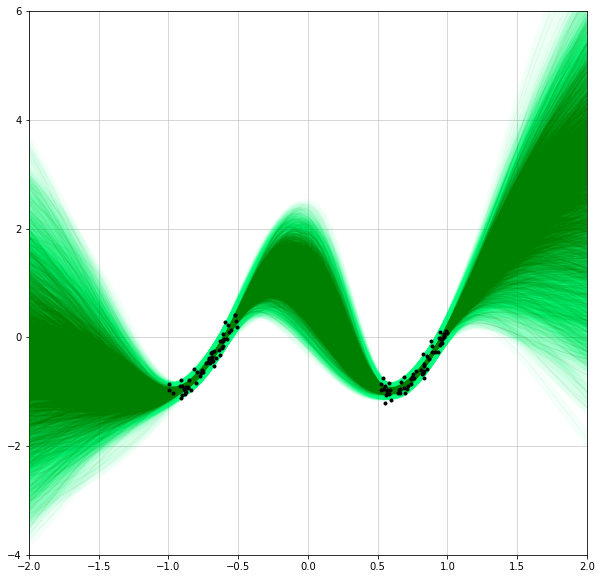

In [61]:
fig=setup.makePlot(torch.as_tensor(samples),device)

In [62]:
import emcee
emcee.autocorr.integrated_time(samples, c=5, tol=50, quiet=False)

array([52.99842366])

In [63]:
theta=torch.load('mlruns/1/07280cf8fae54c91a363e8ad2cc60b22/artifacts/theta.pt')



In [64]:
emcee.autocorr.integrated_time(theta, c=5, tol=50, quiet=False)

array([52.99842366])

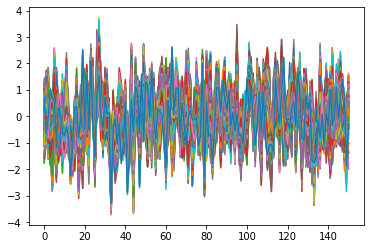

In [71]:
%matplotlib inline
for i in range(theta.shape[1]):
    plt.plot(theta[i])

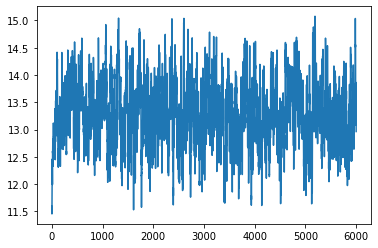

In [76]:
plt.plot(torch.as_tensor(theta).norm(dim=1))

In [75]:
theta.shape

torch.Size([6000, 151])